# Nuovi Decessi e Terapie Intensive

Correlazione tra nuovi deceduti e terapie intensive.

> Max Pierini

In [1]:
import random
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import dates as mdates
import matplotlib.gridspec as gridspec
import statsmodels.api as sm

from IPython.display import Markdown

In [2]:
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    index_col='data', parse_dates=['data']
).sort_values('data')

In [4]:
def covid_regioni():
    df = pd.read_csv(
        "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
        parse_dates=['data'],
        index_col=['data'],
        squeeze=True).sort_index()
    df.index = df.index.normalize()
    return df

In [5]:
ti_it = df.ingressi_terapia_intensiva.dropna()

In [6]:
rg = covid_regioni()

ti_rg = rg[['denominazione_regione', 'ingressi_terapia_intensiva']].dropna()

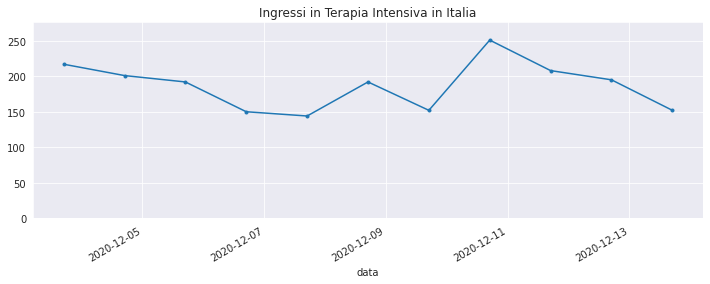

In [7]:
ti_it.plot(
    ylim=(0,ti_it.values.max()*1.1), 
    marker='.',
    title='Ingressi in Terapia Intensiva in Italia',
    figsize=(12, 4)
)
plt.show()

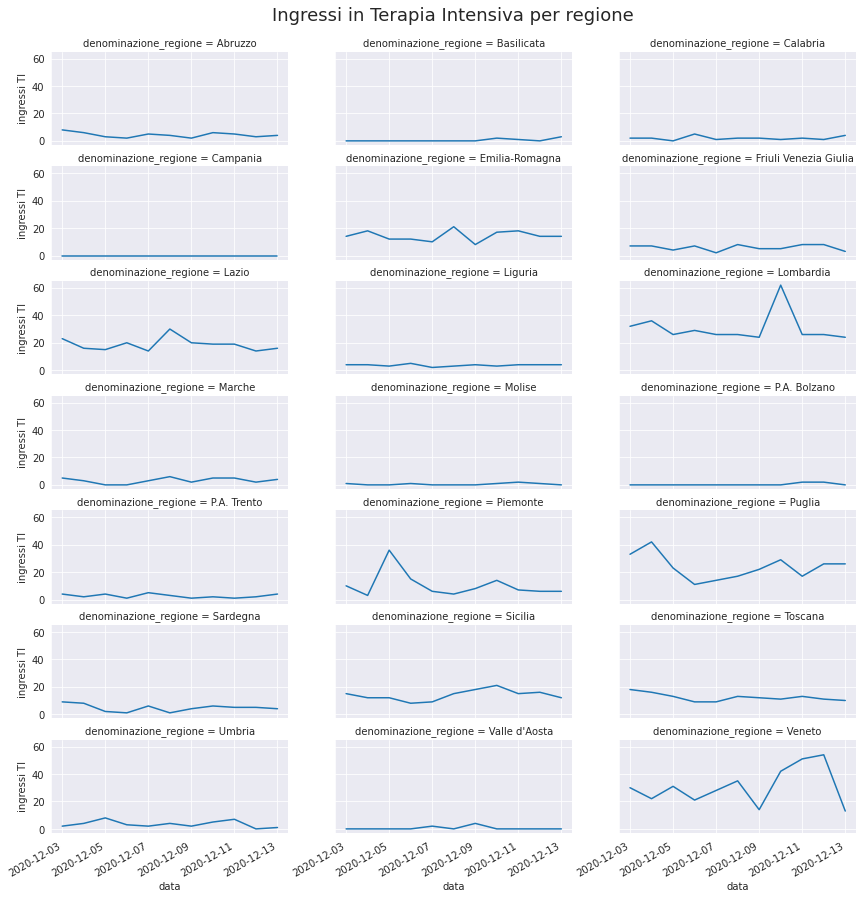

In [8]:
g = sns.relplot(
    kind='line',
    data=ti_rg,
    x='data', y='ingressi_terapia_intensiva',
    col='denominazione_regione', col_wrap=3,
    aspect=2, height=2,
)
g.fig.autofmt_xdate()
g.set_ylabels('ingressi TI')
g.fig.suptitle('Ingressi in Terapia Intensiva per regione', y=1.02, fontsize=18)
plt.show()

In [9]:
df['nuovi_deceduti'] = df.deceduti.diff()

In [10]:
df['dec_int_rate'] = df.nuovi_deceduti / df.terapia_intensiva

In [11]:
df['dec_int_rate_filtered'] = df.dec_int_rate

Rapporto grezzo nuovi deceduti su terapie intensive:

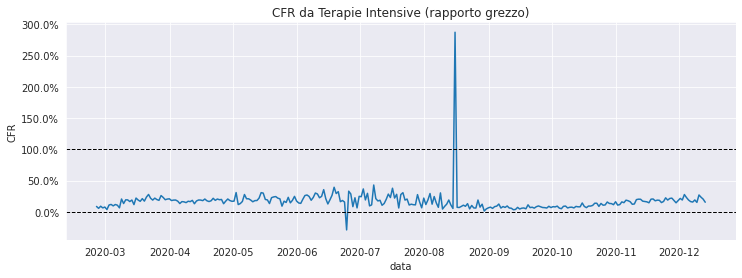

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(
    data=df,
    x='data', y='dec_int_rate',
    ax=ax
)
ax.axhline(0, ls='--', lw=1, color='k')
ax.axhline(1, ls='--', lw=1, color='k')
ax.set(
    ylabel='CFR',
    title='CFR da Terapie Intensive (rapporto grezzo)'
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
plt.show()

Definizione e rimozione outliers (minori di 0% e maggiori di 100%)

In [13]:
outliers = ((df.dec_int_rate > 1) | (df.dec_int_rate < 0)).values.nonzero()
for outlier in outliers:
    for idx in outlier:
        print(f"{df.index[idx]}: {df.dec_int_rate[idx]:.2%}")
        df.at[df.index[idx], 'dec_int_rate_filtered'] = df.iloc[idx-1]['dec_int_rate_filtered']

2020-06-24 17:00:00: -28.97%
2020-08-15 17:00:00: 287.27%


Fit su polinomio di ottavo grado

In [14]:
params = np.polyfit(
    np.array(range(df.index.size))[1:], df.dec_int_rate_filtered.values[1:], 8
)
func = np.poly1d(params)
fitted = func(np.array(range(df.index.size))[1:])

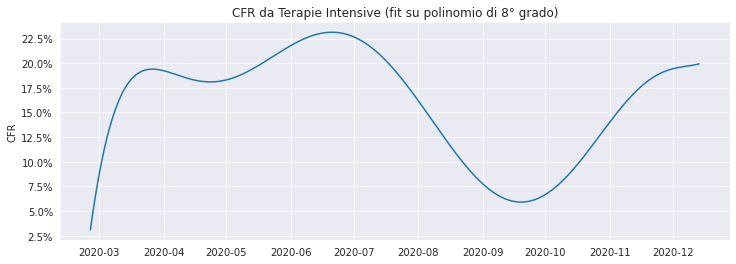

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index[1:], fitted)
ax.set(
    ylabel='CFR',
    title='CFR da Terapie Intensive (fit su polinomio di 8° grado)'
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
plt.show();

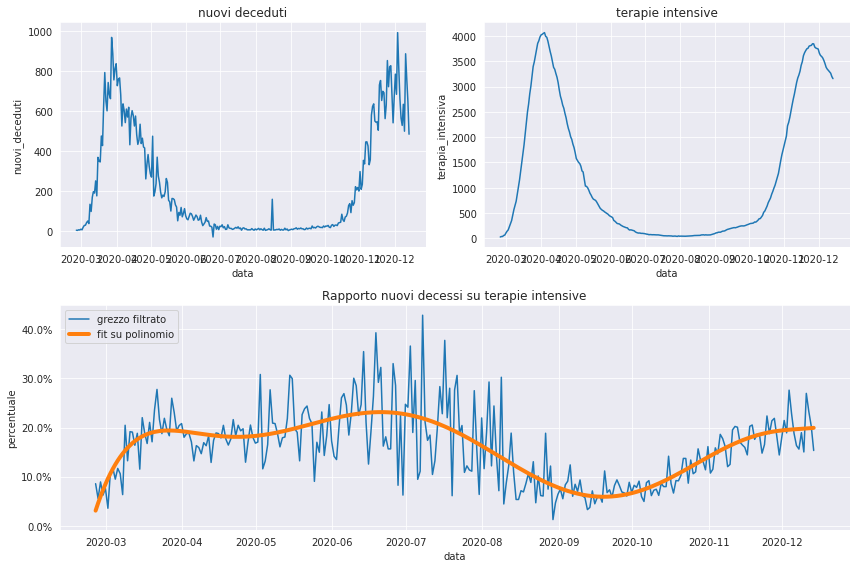

In [16]:
fig = plt.figure(tight_layout=True, figsize=(12, 8))
gs = gridspec.GridSpec(2, 2)

ax_sn = fig.add_subplot(gs[0, 0])
sns.lineplot(data=df, x='data', y='nuovi_deceduti', ax=ax_sn)
ax_sn.set_title('nuovi deceduti')

ax_dx = fig.add_subplot(gs[0, 1])
sns.lineplot(data=df, x='data', y='terapia_intensiva', ax=ax_dx)
ax_dx.set_title('terapie intensive')

ax = fig.add_subplot(gs[1, :])
sns.lineplot(
    data=df,
    x='data', y='dec_int_rate_filtered', 
    label='grezzo filtrato',
    ax=ax
)
ax.plot(df.index[1:], fitted, lw=4, label='fit su polinomio')
ax.legend(loc='upper left')
ax.set_ylabel('percentuale')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
ax.set_title('Rapporto nuovi decessi su terapie intensive')
plt.show()

Correlazione sulla linea temporale

In [17]:
df['mese'] = [f"{y} {m}" for y, m in zip(df.index.year, df.index.month_name())]

In [18]:
df['mese_num'] = [int(f"{y}{m}") for y, m in zip(df.index.year, df.index.month)]

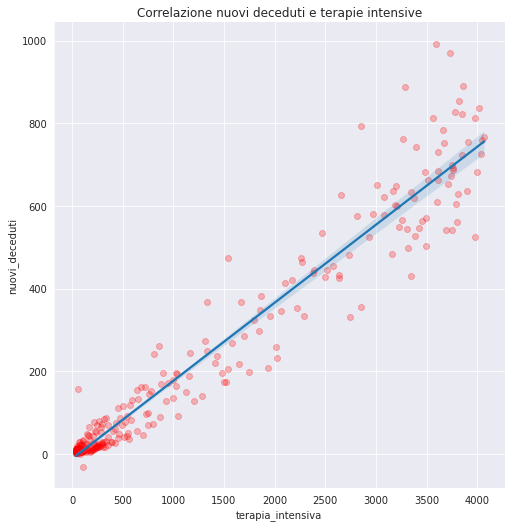

In [19]:
g = sns.lmplot(
    data=df,
    x='terapia_intensiva', y='nuovi_deceduti',
    x_jitter=.3, y_jitter=.3,
    order=1,
    height=7,
    scatter_kws={'alpha':.25, 'color':'r'}
)
g.set(
    title='Correlazione nuovi deceduti e terapie intensive'
)
plt.show()

In [20]:
model = sm.OLS.from_formula('nuovi_deceduti ~ terapia_intensiva - 1', data=df)
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         nuovi_deceduti   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                              7835.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):                   5.92e-213
Time:                        16:44:47   Log-Likelihood:                         -1641.7
No. Observations:                 293   AIC:                                      3285.
Df Residuals:                     292   BIC:                                      3289.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
terapia_intensiva     0.1845      0.002     88.516      0.000       0.180       0.189
==============================================================================
Omnibus:                       95.006   Durbin-Watson:                   1.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.711
Skew:                           1.227   Prob(JB):                    1.68e-107
Kurtosis:                       8.853   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
fit_res = {}
grouped = df.groupby('mese_num')
for mese in grouped:
    try:
        fit_res.update({mese[0]: {}})
        _df = mese[1][['nuovi_deceduti', 'terapia_intensiva']]
        model = sm.OLS.from_formula('nuovi_deceduti ~ terapia_intensiva', data=_df[1:])
        results = model.fit()
        fit_res[mese[0]]['R2'] = results.rsquared
        fit_res[mese[0]]['Intercept'] = results.params.Intercept
        fit_res[mese[0]]['coefficient'] = results.params.terapia_intensiva
    except Exception as err:
        print(err)

Correlazione nuovi deceduti e terapie intensive per mese:

$$
\textrm{nuovi_deceduti}_{\textrm{mese}} = \alpha + \beta \cdot \textrm{terapia_intensiva}_{\textrm{mese}}
$$

dove $\alpha$ è l'intercetta e $\beta$ il coefficiente di correlazione.

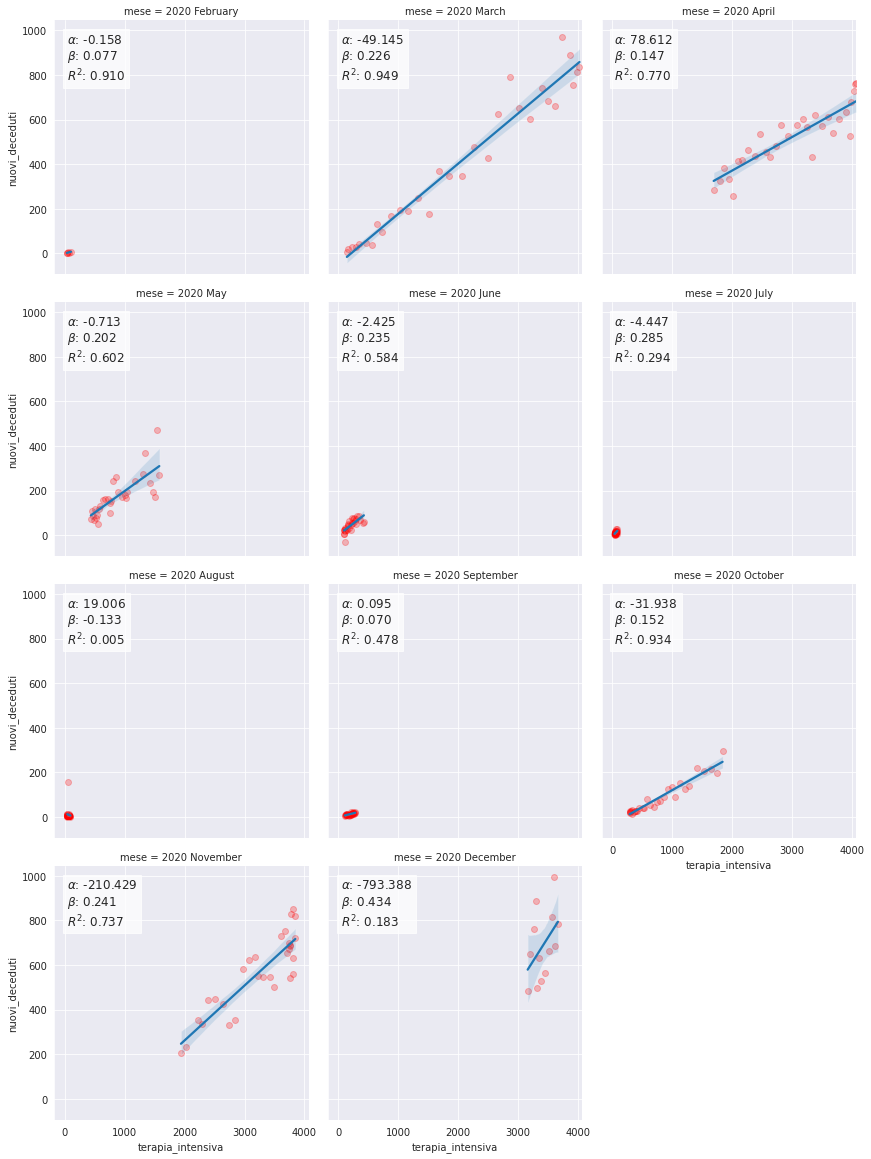

In [22]:
params = {}

g = sns.lmplot(
    data=df,
    x='terapia_intensiva', y='nuovi_deceduti',
    x_jitter=.3, y_jitter=.3,
    order=1,
    height=4, col='mese', col_wrap=3,
    #sharex=False, 
    #sharey=False,
    scatter_kws={'alpha':.25, 'color':'r'}
)
months = df.mese.unique()
for i, res in enumerate(fit_res):
    xlim = g.axes.flat[i].get_xlim()
    ylim = g.axes.flat[i].get_ylim()
    
    res_txt = "not enough data"
    try:
        res_txt = fr"$\alpha$: {fit_res[res]['Intercept']:.3f}"+\
        "\n"+\
        fr"$\beta$: {fit_res[res]['coefficient']:.3f}"+\
        "\n"+\
        fr"$R^2$: {fit_res[res]['R2']:.3f}"
    except Exception as err:
        print(res, err)
    
    g.axes.flat[i].text(
        0.05, 0.85,
        res_txt,
        ha='left', va='center', fontsize=12,
        transform=g.axes.flat[i].transAxes,
        bbox=dict(facecolor='w', alpha=0.75)
    )
    try:
        params.update({months[i]: {
            'alpha': fit_res[res]['Intercept'], 
            'beta': fit_res[res]['coefficient'],
            'R2': fit_res[res]['R2']
        }})
    except Exception as err:
        print(res, err)

In [23]:
pd.DataFrame(params).T

,alpha,beta,R2
2020 February,-0.158044,0.076994,0.910127
2020 March,-49.144705,0.225814,0.949058
2020 April,78.611993,0.147042,0.770331
2020 May,-0.712653,0.201721,0.602185
2020 June,-2.425303,0.234926,0.583532
2020 July,-4.446567,0.284943,0.294261
2020 August,19.005875,-0.132562,0.004537
2020 September,0.094984,0.069851,0.478192
2020 October,-31.937616,0.152086,0.933634
2020 November,-210.428602,0.240524,0.737407


In [24]:
lines = {
    'mese': [], 'terapia intensiva': [], 'nuovi deceduti': [], 'R2': []
}
x = np.linspace(0, df.terapia_intensiva.max(), 2)
for i, mese in enumerate(params):
    lines['mese'].append(mese)
    lines['mese'].append(mese)
    lines['terapia intensiva'].append(x[0])
    lines['terapia intensiva'].append(x[1])
    _y = params[mese]['alpha'] + params[mese]['beta'] * x
    lines['nuovi deceduti'].append(_y[0])
    lines['nuovi deceduti'].append(_y[1])
    lines['R2'].append(params[mese]['R2'])
    lines['R2'].append(params[mese]['R2'])

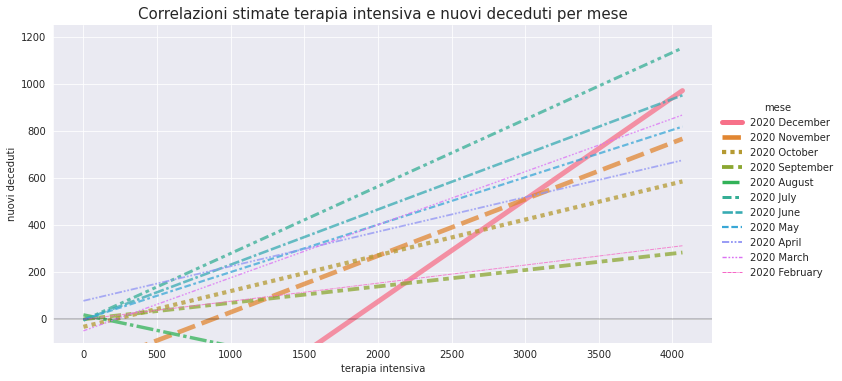

In [25]:
g = sns.relplot(
    kind='line',
    data=pd.DataFrame(lines).iloc[::-1],
    x='terapia intensiva', y='nuovi deceduti',
    hue='mese', size='mese', sizes=(1, 5), style='mese',
    alpha=.75,
    aspect=2
)
g.axes.flat[0].set_title('Correlazioni stimate terapia intensiva e nuovi deceduti per mese', fontsize=15)
ylim = g.axes.flat[0].get_ylim()
g.axes.flat[0].set(
    ylim=(-100, ylim[1])
)
g.axes.flat[0].axhline(0, color='k', alpha=.25)
plt.show()